In [1]:
import os
import time
import copy
import random
from dataclasses import dataclass
from typing import Dict, Any, Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# CIFAR-10 normalization stats (common baseline)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

data_root = "./data"

full_train = torchvision.datasets.CIFAR10(
    root=data_root, train=True, download=True, transform=train_transform
)

test_set = torchvision.datasets.CIFAR10(
    root=data_root, train=False, download=True, transform=test_transform
)

# Split train into train/val
val_ratio = 0.1
val_size = int(len(full_train) * val_ratio)
train_size = len(full_train) - val_size

train_set, val_set = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))

classes = full_train.classes
len(train_set), len(val_set), len(test_set), classes

100%|████████████████████████████████████████| 170M/170M [00:16<00:00, 10.2MB/s]


(45000,
 5000,
 10000,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [4]:
def make_loaders(batch_size: int, num_workers: int = 2) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.3):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16x16
            nn.Dropout(dropout),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 8x8
            nn.Dropout(dropout),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 4x4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [6]:
@torch.no_grad()
def accuracy_from_logits(logits: torch.Tensor, y: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

def train_one_epoch(model, loader, criterion, optimizer, device) -> Tuple[float, float]:
    model.train()
    running_loss, running_acc, n_batches = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return running_loss / n_batches, running_acc / n_batches

@torch.no_grad()
def evaluate(model, loader, criterion, device) -> Tuple[float, float]:
    model.eval()
    running_loss, running_acc, n_batches = 0.0, 0.0, 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item()
        running_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return running_loss / n_batches, running_acc / n_batches

In [7]:
def make_optimizer(params, optimizer_name: str, lr: float, weight_decay: float):
    optimizer_name = optimizer_name.lower()
    if optimizer_name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if optimizer_name == "sgd":
        return optim.SGD(params, lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    raise ValueError(f"Unknown optimizer: {optimizer_name}")

In [8]:
@dataclass
class TrainConfig:
    epochs: int = 12
    patience: int = 3              # early stopping patience on val accuracy
    save_dir: str = "./checkpoints"

os.makedirs("./checkpoints", exist_ok=True)

def fit_model(hparams: Dict[str, Any], cfg: TrainConfig) -> Dict[str, Any]:
    """
    hparams keys:
      - batch_size
      - optimizer
      - lr
      - weight_decay
      - dropout
    """
    batch_size = hparams["batch_size"]
    optimizer_name = hparams["optimizer"]
    lr = hparams["lr"]
    weight_decay = hparams["weight_decay"]
    dropout = hparams["dropout"]

    train_loader, val_loader, test_loader = make_loaders(batch_size=batch_size)

    model = SimpleCNN(num_classes=10, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = make_optimizer(model.parameters(), optimizer_name, lr=lr, weight_decay=weight_decay)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    best_state = None
    best_val_acc = -1.0
    best_epoch = -1
    no_improve = 0

    start_time = time.time()

    for epoch in range(1, cfg.epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        va_loss, va_acc = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        print(
            f"Epoch {epoch:02d}/{cfg.epochs} | "
            f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
            f"val loss {va_loss:.4f} acc {va_acc:.4f}"
        )

        # early stopping on val acc
        if va_acc > best_val_acc + 1e-4:
            best_val_acc = va_acc
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= cfg.patience:
                print(f"Early stopping: no improvement for {cfg.patience} epochs.")
                break

    elapsed = time.time() - start_time

    # Load best and compute test metrics
    if best_state is not None:
        model.load_state_dict(best_state)

    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # Save best checkpoint
    tag = f"cnn_{optimizer_name}_lr{lr}_bs{batch_size}_wd{weight_decay}_do{dropout}".replace(".", "p")
    ckpt_path = os.path.join(cfg.save_dir, f"{tag}.pt")
    torch.save({"hparams": hparams, "state_dict": model.state_dict(), "history": history}, ckpt_path)

    return {
        "hparams": hparams,
        "history": history,
        "best_val_acc": best_val_acc,
        "best_epoch": best_epoch,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "ckpt_path": ckpt_path,
        "time_sec": elapsed,
    }

In [9]:
cfg = TrainConfig(epochs=12, patience=3, save_dir="./checkpoints")

search_space = {
    "batch_size":  [64, 128],
    "optimizer":   ["adam", "sgd"],
    "lr":          [1e-3, 3e-4],
    "weight_decay":[0.0, 1e-4],
    "dropout":     [0.2, 0.4],
}

def grid_params(space: Dict[str, List[Any]]) -> List[Dict[str, Any]]:
    keys = list(space.keys())
    combos = [[]]
    for k in keys:
        combos = [c + [(k, v)] for c in combos for v in space[k]]
    return [dict(c) for c in combos]

param_list = grid_params(search_space)
len(param_list)

32

In [10]:
results = []
best = None

for i, hparams in enumerate(param_list, start=1):
    print("="*90)
    print(f"Run {i}/{len(param_list)} | hparams = {hparams}")
    out = fit_model(hparams, cfg)
    results.append(out)

    if best is None or out["best_val_acc"] > best["best_val_acc"]:
        best = out
        print(f">>> NEW BEST by val_acc: {best['best_val_acc']:.4f} | test_acc {best['test_acc']:.4f}")

print("\nBEST RUN SUMMARY")
print(best["hparams"])
print(f"best_val_acc={best['best_val_acc']:.4f} at epoch {best['best_epoch']}")
print(f"test_acc={best['test_acc']:.4f}, test_loss={best['test_loss']:.4f}")
print(f"checkpoint: {best['ckpt_path']}")

Run 1/32 | hparams = {'batch_size': 64, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 0.0, 'dropout': 0.2}


/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/12 | train loss 1.5222 acc 0.4362 | val loss 1.3931 acc 0.4814
Epoch 02/12 | train loss 1.1490 acc 0.5892 | val loss 1.1177 acc 0.6072
Epoch 03/12 | train loss 1.0010 acc 0.6444 | val loss 0.8549 acc 0.6932
Epoch 04/12 | train loss 0.9076 acc 0.6771 | val loss 0.8350 acc 0.7033
Epoch 05/12 | train loss 0.8442 acc 0.7041 | val loss 0.7353 acc 0.7336
Epoch 06/12 | train loss 0.8020 acc 0.7199 | val loss 0.7569 acc 0.7288
Epoch 07/12 | train loss 0.7593 acc 0.7322 | val loss 0.6990 acc 0.7547
Epoch 08/12 | train loss 0.7308 acc 0.7444 | val loss 0.6449 acc 0.7779
Epoch 09/12 | train loss 0.7067 acc 0.7546 | val loss 0.6180 acc 0.7854
Epoch 10/12 | train loss 0.6798 acc 0.7651 | val loss 0.6137 acc 0.7838
Epoch 11/12 | train loss 0.6505 acc 0.7774 | val loss 0.6295 acc 0.7846
Epoch 12/12 | train loss 0.6339 acc 0.7801 | val loss 0.5462 acc 0.8103
>>> NEW BEST by val_acc: 0.8103 | test_acc 0.8209
Run 2/32 | hparams = {'batch_size': 64, 'optimizer': 'adam', 'lr': 0.001, 'weight_deca

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x108c75bc0>
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/opt/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1618, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/miniconda3/lib/python3.13/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/miniconda3/lib/python3.13/multiprocessing/popen_fork.py", line 41, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/miniconda3/lib/python3.13/multiprocessing/connection.py", line 1148, in wait
    ready = selector.select(timeout)
  File "/opt/miniconda3/lib/python3.13/selectors.py", line 398, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [11]:
# Simple table without pandas (чтобы не зависеть от окружения)
sorted_results = sorted(results, key=lambda x: x["best_val_acc"], reverse=True)

for r in sorted_results[:10]:
    hp = r["hparams"]
    print(
        f"val_acc={r['best_val_acc']:.4f} | test_acc={r['test_acc']:.4f} | "
        f"opt={hp['optimizer']:<4} lr={hp['lr']:<7} bs={hp['batch_size']:<3} wd={hp['weight_decay']:<6} do={hp['dropout']}"
    )

val_acc=0.8103 | test_acc=0.8209 | opt=adam lr=0.001   bs=64  wd=0.0    do=0.2
val_acc=0.7593 | test_acc=0.7670 | opt=adam lr=0.001   bs=64  wd=0.0    do=0.4


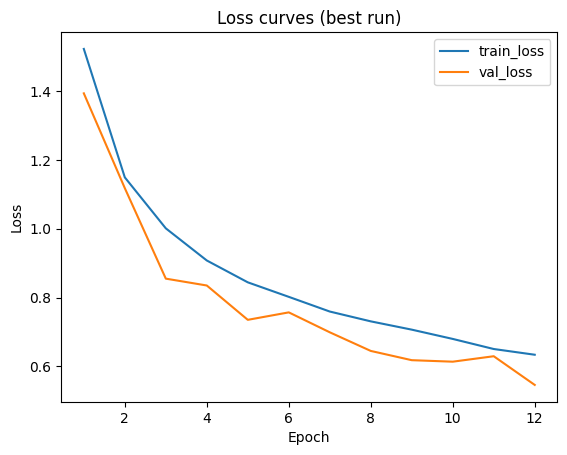

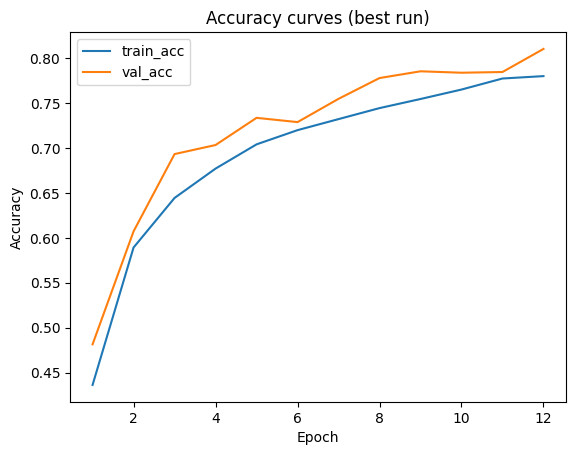

In [12]:
hist = best["history"]
epochs = range(1, len(hist["train_loss"]) + 1)

plt.figure()
plt.plot(list(epochs), hist["train_loss"], label="train_loss")
plt.plot(list(epochs), hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves (best run)")
plt.show()

plt.figure()
plt.plot(list(epochs), hist["train_acc"], label="train_acc")
plt.plot(list(epochs), hist["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy curves (best run)")
plt.show()

In [13]:
ckpt = torch.load(best["ckpt_path"], map_location=device)

model = SimpleCNN(num_classes=10, dropout=ckpt["hparams"]["dropout"]).to(device)
model.load_state_dict(ckpt["state_dict"])

_, _, test_loader = make_loaders(batch_size=ckpt["hparams"]["batch_size"])
criterion = nn.CrossEntropyLoss()

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print("Loaded checkpoint:", best["ckpt_path"])
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

Loaded checkpoint: ./checkpoints/cnn_adam_lr0p001_bs64_wd0p0_do0p2.pt
Test loss: 0.5255, Test accuracy: 0.8209


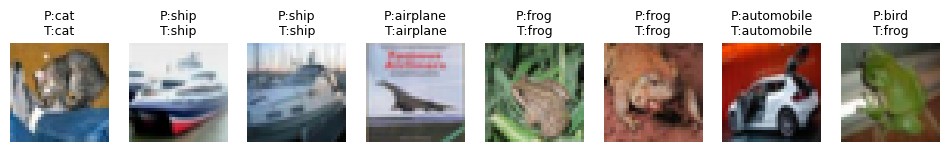

In [14]:
@torch.no_grad()
def show_predictions(model, loader, classes, n: int = 8):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)
    logits = model(images)
    preds = torch.argmax(logits, dim=1)

    # denormalize for display
    mean = torch.tensor(CIFAR10_MEAN).view(1,3,1,1)
    std  = torch.tensor(CIFAR10_STD).view(1,3,1,1)
    imgs = images.cpu() * std + mean
    imgs = torch.clamp(imgs, 0, 1)

    plt.figure(figsize=(12, 3))
    for i in range(min(n, imgs.size(0))):
        plt.subplot(1, min(n, imgs.size(0)), i+1)
        plt.imshow(np.transpose(imgs[i].numpy(), (1,2,0)))
        plt.axis("off")
        plt.title(f"P:{classes[preds[i].item()]}\nT:{classes[labels[i].item()]}", fontsize=9)
    plt.show()

_, _, test_loader = make_loaders(batch_size=best["hparams"]["batch_size"])
show_predictions(model, test_loader, classes, n=8)